In [1]:
#Cài đặt thư viện
import math
import seaborn as sns
import datetime as dt
from datetime import datetime    
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np 
import pandas as pd 
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error,mean_absolute_error

In [2]:
#Data mining
def data_mining(data):
  from statsmodels.tsa.seasonal import seasonal_decompose
  result = seasonal_decompose(data, model='additive', period=20)
  #chuyển giá trị trên trục x nghiêng 45 độ
  result.observed.index = result.observed.index.strftime('%d-%m-%Y')
  #Tạo 4 subplots
  fig, ax = plt.subplots(4, 1, figsize=(10, 8))
  #Thực hiện gắn dữ liệu vào từng subplot
  result.observed.plot(ax=ax[0])
  ax[0].set_ylabel('Observed')
  result.trend.plot(ax=ax[1])
  ax[1].set_ylabel('Trend')
  result.seasonal.plot(ax=ax[2])
  ax[2].set_ylabel('Seasonal')
  result.resid.plot(ax=ax[3])
  ax[3].set_ylabel('Residual')
  plt.tight_layout()
  plt.show()

In [3]:
#Chuẩn hóa dữ liệu
def data_scaling(df):
  scaler=MinMaxScaler()
  df1=scaler.fit_transform(np.array(df).reshape(-1,1))
  return df1, scaler

In [4]:
#window sliding
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX),np.array(dataY)

In [5]:
#Chia dữ liệu
def data_spliting(df1, train_ratio, test_ratio):
  train_size = int(train_ratio * len(df1))
  test_size = int(test_ratio * len(df1))
  val_size = len(df1) - train_size - test_size

  train_data = df1[:train_size]
  test_data = df1[train_size:train_size+test_size]
  val_data = df1[train_size+test_size:]

  return train_data, test_data, val_data

In [6]:
def cnn_lstm_build_model():
  # For creating model and training
  import tensorflow as tf
  from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
  from tensorflow.keras.layers import MaxPooling1D, Flatten
  from tensorflow.keras.regularizers import L1, L2
  from tensorflow.keras.metrics import Accuracy
  from tensorflow.keras.metrics import RootMeanSquaredError
  import tensorflow.keras.backend as K
  from tensorflow.keras.utils import plot_model

  model = tf.keras.Sequential()

  # Creating the Neural Network model here...
  # CNN layers
  model.add(TimeDistributed(Conv1D(256, kernel_size=3, activation='relu', input_shape=(None, 14, 1))))
  model.add(TimeDistributed(MaxPooling1D(2)))
  model.add(TimeDistributed(Conv1D(128, kernel_size=3, activation='relu')))
  model.add(TimeDistributed(MaxPooling1D(2)))
  model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu')))
  model.add(TimeDistributed(MaxPooling1D(2)))
  model.add(TimeDistributed(Flatten()))
  # model.add(Dense(5, kernel_regularizer=L2(0.01)))

  # LSTM layers
  model.add(Bidirectional(LSTM(100, return_sequences=True)))
  model.add(Dropout(0.5))
  model.add(Bidirectional(LSTM(100, return_sequences=False)))
  model.add(Dropout(0.5))

  def root_mean_squared_error(y_true, y_pred):
          return K.sqrt(K.mean(K.square(y_pred - y_true))) 

  #Final layers
  model.add(Dense(1, activation='linear'))
  model.compile(optimizer='adam', loss=root_mean_squared_error, metrics=['mse', 'mae'])



  return model

In [7]:
def cnn_lstm_next30days(model, scaler ,val_label_inverse, val_data_df, time_step):
  next30days_index=pd.date_range(val_data_df[-1:].index.date[0],periods = 30 ,freq='D')
  pred_next = np.array([])
  
  val_label_inverse=val_label_inverse[-time_step:].reshape(1,-1).reshape(1,time_step)
  
  for i in range(30):
    y_pred_next = model.predict(val_label_inverse.reshape(1,-1).reshape(1,1,time_step,1))
    val_label_inverse = np.append(val_label_inverse,y_pred_next[0])[1:]
    pred_next = np.append(pred_next,y_pred_next[0])
    
  next30days_predict_inverse = pd.DataFrame(scaler.inverse_transform(pred_next.reshape(-1,1)), index = next30days_index)
  return next30days_predict_inverse

In [8]:
def cnn_lstm_fit(X_train, y_train,X_test, y_test,X_val, y_val, time_step, scaler, train_data_df, test_data_df, val_data_df, model_name):
  from keras.callbacks import EarlyStopping
  early_stopping = EarlyStopping(monitor='val_loss', patience=40, verbose = 2)
  
  model = cnn_lstm_build_model()
  print("model is built")
  history = model.fit(X_train.reshape(X_train.shape[0],1,time_step,1), np.array(y_train), validation_data=(X_test.reshape(X_test.shape[0],1,time_step,1), np.array(y_test)), epochs=100,batch_size=40, verbose=1, shuffle = True, callbacks=[early_stopping])

  #dự đoán tập test
  test_predict = model.predict(X_test.reshape(X_test.shape[0],1,time_step,1))
  test_predict_inverse = scaler.inverse_transform(test_predict.reshape(-1,1))
  test_label_inverse = scaler.inverse_transform(y_test.reshape(-1,1))
  deviation(test_label_inverse, test_predict_inverse)
  test_predict_inverse = pd.DataFrame(test_predict_inverse, index = test_data_df[(time_step+1):].index)
  test_label_inverse = pd.DataFrame(test_label_inverse, index = test_data_df[(time_step+1):].index)
  visualize(test_label_inverse, test_predict_inverse, model_name)

  #dự đoán tập validate
  val_predict= model.predict(X_val.reshape(X_val.shape[0],1,time_step,1))
  val_predict_inverse =scaler.inverse_transform(val_predict.reshape(-1,1))
  val_label_inverse = scaler.inverse_transform(y_val.reshape(-1,1))
  deviation(val_label_inverse, val_predict_inverse)
  val_predict_inverse = pd.DataFrame(val_predict_inverse, index = val_data_df[(time_step+1):].index)
  val_label_inverse = pd.DataFrame(val_label_inverse, index = val_data_df[(time_step+1):].index)
  
  visualize(val_label_inverse, val_predict_inverse, model_name)



  next30_predict_inverse = cnn_lstm_next30days(model, scaler , y_val, val_data_df, time_step)
  visualize_overview(train_data_df, test_data_df, val_data_df, test_predict_inverse, val_predict_inverse, next30_predict_inverse, model_name)

In [9]:
def visualize(label ,pred, model_name):
  plt.figure(figsize=(16,9))
  plt.plot(label, label = 'Ground truth')
  plt.plot(pred, label='Predict')
  plt.title(model_name)
  plt.xlabel('Date')
  plt.ylabel('Closing Price')
  plt.legend()
  plt.show()

In [10]:
#Visualization
def visualize_overview(train_data_df,test_data_df, val_data_df, test_predict_inverse, val_predict_inverse, next30_predict_inverse, model_name):

  plt.figure(figsize=(16,9))
  #train label
  plt.plot(train_data_df, label = 'Train')

  #test label and predict value
  plt.plot(test_data_df, label = 'Test')
  plt.plot(test_predict_inverse, label='Predict')

  #val label and predict value
  plt.plot(val_data_df, label = 'Validate')
  plt.plot(val_predict_inverse, label='ValidatePred')

  #predict next 30 days value
  # plt.plot(next30_predict_inverse, label = 'Predict30days')


  plt.title(model_name)
  plt.xlabel('Date')
  plt.ylabel('Closing Price')
  plt.legend()
  plt.grid(False)
  plt.show()

In [11]:
def mda_cal(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - actual[:-1])).astype(int))

In [12]:
#Đánh giá 
def deviation(test, pred):
  rmse=np.sqrt(mean_squared_error(test,pred))
  print(f"RMSE: {rmse:.2f}")
  mape=mean_absolute_percentage_error(test,pred)
  print(f"MAPE: {mape*100:.2f}%")
  mda = mda_cal(test, pred)
  print(f"MDA: {mda*100:.2f}%")

In [13]:
#Chọn dataset, tỉ lệ và 
def data_preprocessing(data_src, train_ratio, test_ratio, time_step, model_name):
  df = pd.read_csv(data_src, parse_dates=True,
                       index_col=0).sort_values(by='Date', ascending=True)
  #Xóa dấu , và chuyển về float
  df['Price']=df['Price'].replace(',','',regex=True).astype(float)
  df['Open']=df['Open'].astype(str).str.replace(',','').astype(float)
  df['High']=df['High'].astype(str).str.replace(',','').astype(float)
  df['Low']=df['Low'].astype(str).str.replace(',','').astype(float)
  df['Change %']=df['Change %'].astype(str).str.replace('%','').astype(float)

  #Thực hiện tách chuỗi KL thành 1 chuỗi số float và 1 ký tự cuối sau đó lấy số float đó nhân với 1000 
  #nếu ký tự cuối là K, nếu là M thì nhân với 1000000, nếu không có K hay M thì trả về số float đó
  def convert_value(value):
      if isinstance(value, str):
          if value.endswith('K'):
              return float(value[:-1]) * 1000
          elif value.endswith('M'):
              return float(value[:-1]) * 1000000
          else:
              return float(value)
      else:
          return value

  df['Vol.'] = df['Vol.'].apply(convert_value)

  df = df[['Price']]

  data_mining(df)

  df1, scaler = data_scaling(df)
  
  train_data_df, test_data_df, val_data_df = data_spliting(df,train_ratio, test_ratio)
  train_data, test_data, val_data = data_spliting(df1,train_ratio, test_ratio)

  X_train, y_train = create_dataset(train_data, time_step)
  X_test, y_test = create_dataset(test_data, time_step)
  X_val, y_val = create_dataset(val_data, time_step)

  model =  cnn_lstm_fit(X_train, y_train,X_test, y_test,X_val, y_val, time_step, scaler, train_data_df, test_data_df, val_data_df, model_name)


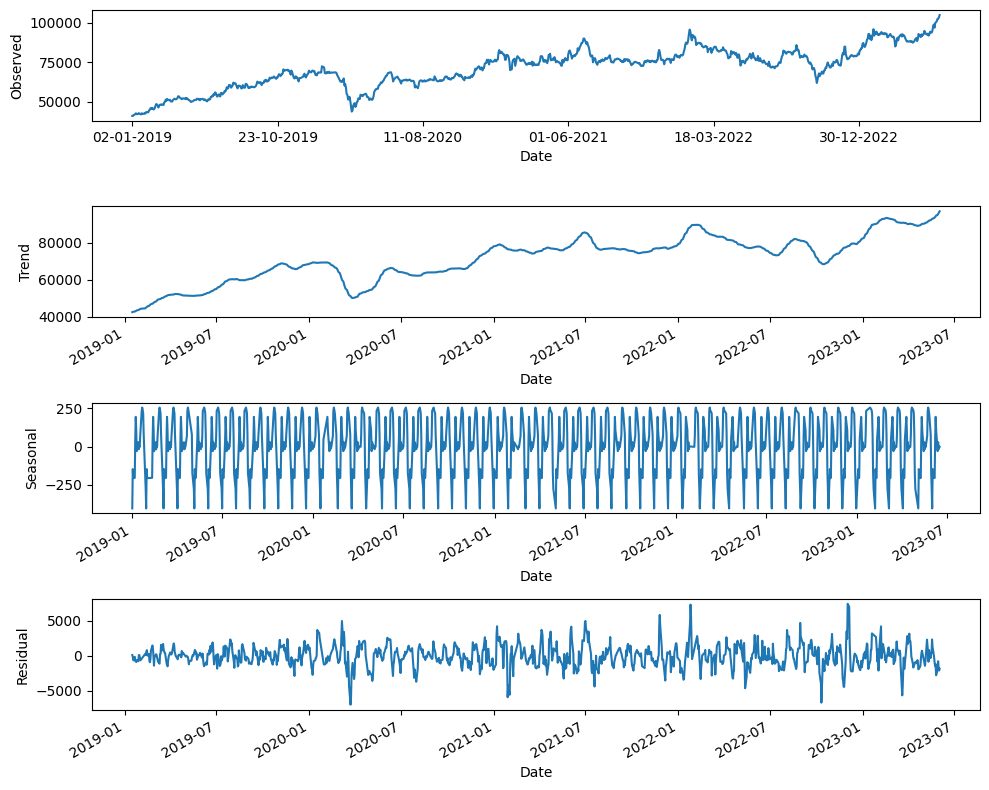

model is built
Epoch 1/100
19/19 [==============================] - 75s 410ms/step - loss: 0.2151 - mse: 0.0602 - mae: 0.1892 - val_loss: 0.0837 - val_mse: 0.0077 - val_mae: 0.0684
Epoch 2/100
19/19 [==============================] - 1s 41ms/step - loss: 0.1012 - mse: 0.0104 - mae: 0.0763 - val_loss: 0.0800 - val_mse: 0.0072 - val_mae: 0.0680
Epoch 3/100
19/19 [==============================] - 1s 35ms/step - loss: 0.0897 - mse: 0.0082 - mae: 0.0677 - val_loss: 0.0931 - val_mse: 0.0095 - val_mae: 0.0805
Epoch 4/100
19/19 [==============================] - 1s 35ms/step - loss: 0.0903 - mse: 0.0084 - mae: 0.0682 - val_loss: 0.0766 - val_mse: 0.0066 - val_mae: 0.0645
Epoch 5/100
19/19 [==============================] - 1s 42ms/step - loss: 0.0930 - mse: 0.0089 - mae: 0.0707 - val_loss: 0.0765 - val_mse: 0.0065 - val_mae: 0.0643
Epoch 6/100
19/19 [==============================] - 1s 34ms/step - loss: 0.0856 - mse: 0.0075 - mae: 0.0642 - val_loss: 0.0680 - val_mse: 0.0051 - val_mae: 0.0550

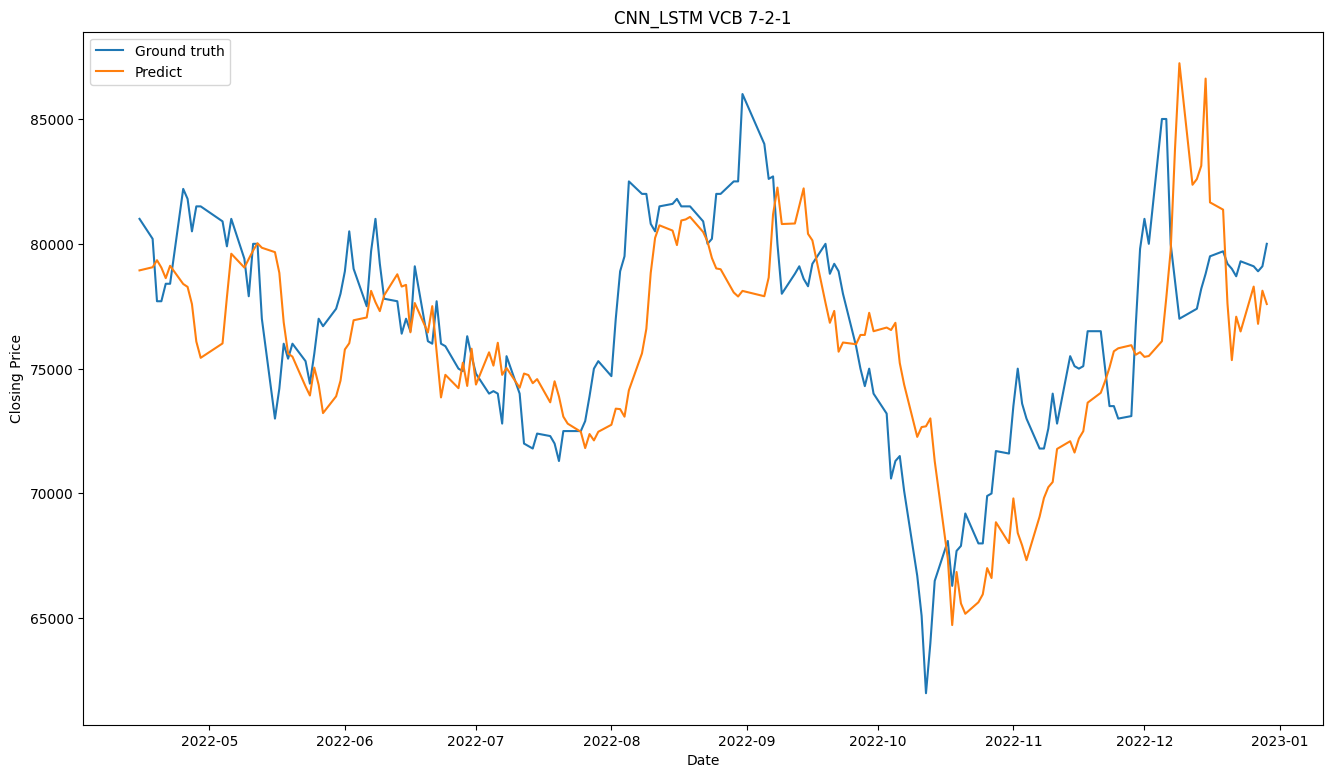

3/3 [==============================] - 0s 7ms/step
RMSE: 9211.44
MAPE: 9.41%
MDA: 42.86%


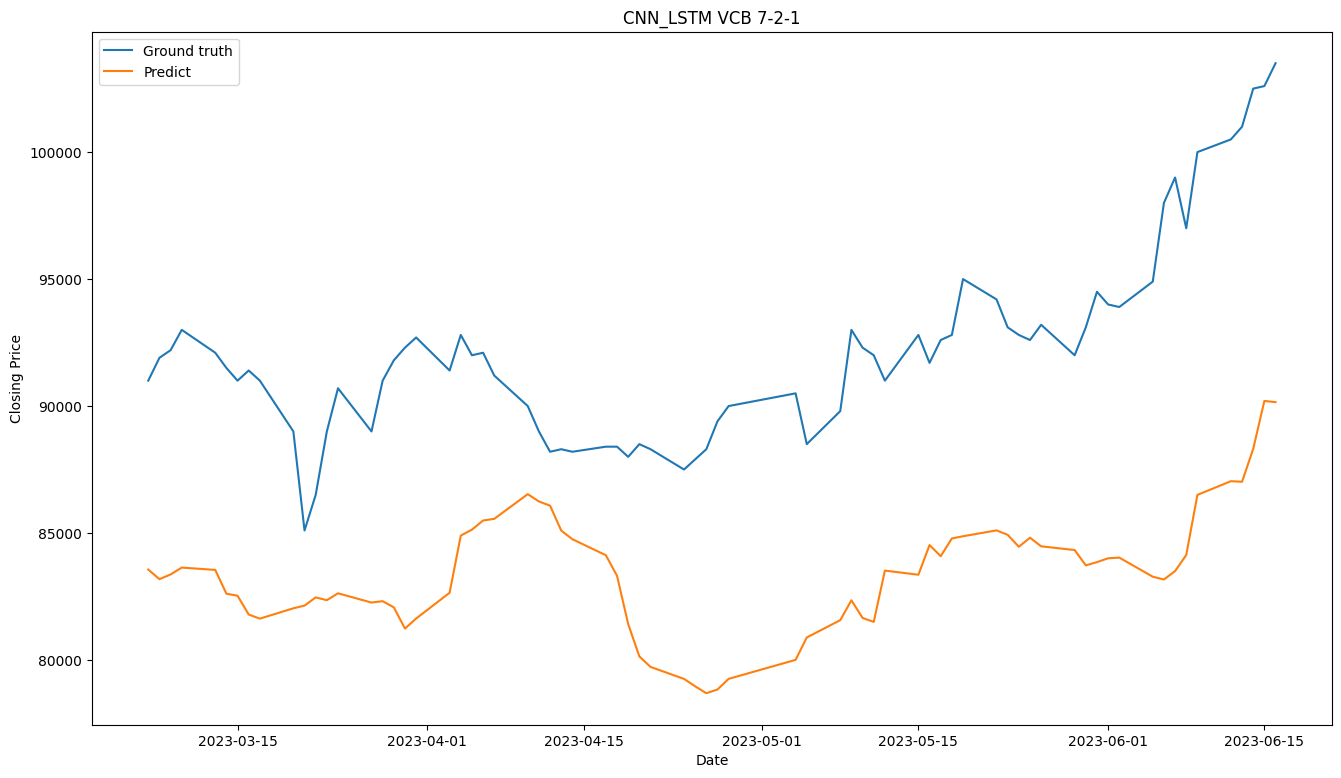

1/1 [==============================] - 0s 86ms/step


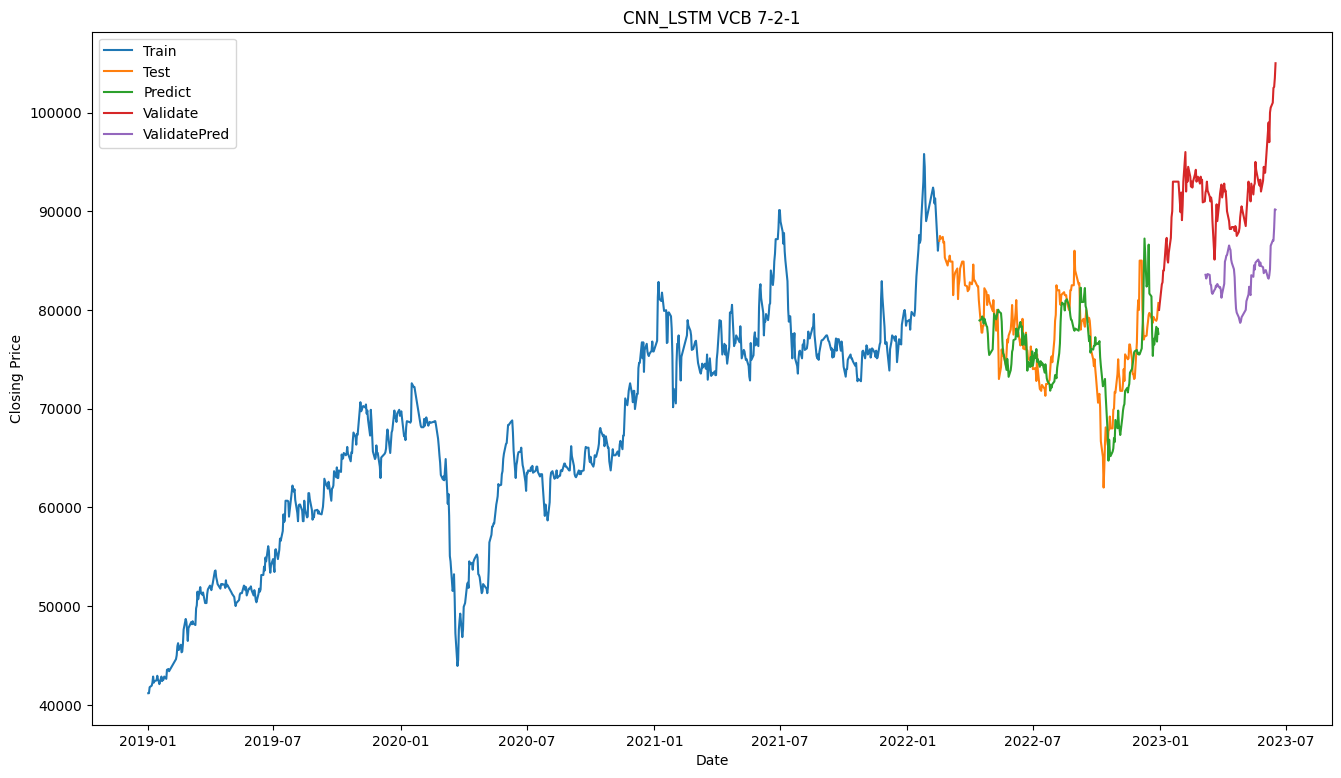

In [14]:
data_preprocessing('VCB-Historical-Data.csv', 0.7, 0.2, 40, "CNN_LSTM VCB 7-2-1")